# Machine learning con modelos basados en árboles en Python


In [42]:
import pandas as pd
import plotnine as pn
import sklearn
import sklearn.tree
import sklearn.pipeline
import sklearn.compose
import sklearn.ensemble
import numpy as np
import xgboost
from matplotlib import pyplot as plt
import statsmodels.api as sm


data_location = "tweet_and_user_data.csv"

pd.options.display.max_columns = 500

In [2]:
tweet_data = pd.read_csv(data_location, low_memory=False)

In [3]:
tweet_data.shape

(40581, 56)

In [4]:
tweet_data.head(3)

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,id_user,name_user,username_user,bio,url,join_datetime,join_date,join_time,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,409486555,MichelleObama,Michelle Obama,4,0,https://twitter.com/MichelleObama/status/14255...,[],[],0,NaN,True,0,0,232,0,NaN,NaN,NaN,NaN,1.047165e+18,We're so proud of the four organizations in ou...,1.425590e+18,[],2021-08-12 00:46:58 CEST,NaN,NaN,NaN,409486555,Michelle Obama,MichelleObama,Girl from the South Side and former First Lady...,https://t.co/HPYP9ad13Y,2011-11-10 20:13:01 UTC,2011-11-10,20:13:01 UTC,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],21447363,21447363,katyperry,KATY PERRY,2,22,https://twitter.com/katyperry/status/142773686...,[],['https://pbs.twimg.com/media/E9BXG4YVkAAl3_A....,1,https://pbs.twimg.com/media/E9BXG4YVkAAl3_A.jpg,False,5266,368,408,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766730...,[],[],0,NaN,True,0,0,764,0,NaN,NaN,NaN,NaN,2.597252e+08,You are not your job.,1.427648e+18,[],2021-08-17 17:05:53 CEST,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...


In [5]:
tweet_data["nlikes"]

0           0
1        5266
2           0
3        5638
4        8810
         ... 
40576     961
40577     224
40578     240
40579    1357
40580    4085
Name: nlikes, Length: 40581, dtype: int64

## Nuestra prediccion


In [6]:
tweet_data.nlikes.quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50       39.0
0.75      198.0
0.90     1318.0
0.95     4319.0
0.99    25868.0
Name: nlikes, dtype: float64

In [7]:
tweet_data.nlikes.describe()

count    4.058100e+04
mean     1.333355e+03
std      1.802289e+04
min      0.000000e+00
25%      6.000000e+00
50%      3.900000e+01
75%      1.980000e+02
max      1.920242e+06
Name: nlikes, dtype: float64

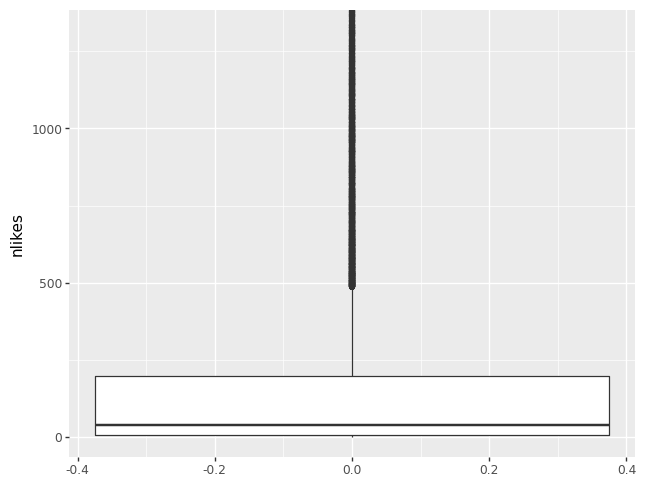

In [8]:
graph = (
    pn.ggplot(tweet_data, pn.aes(x="0", y="nlikes"))
    + pn.geom_boxplot()
    + pn.coord_cartesian(ylim=[0, tweet_data.nlikes.quantile(0.90)])
    + pn.xlab("")
)

graph.draw()

In [9]:
target = "is_popular"
cutoff = 200
tweet_data[target] = (tweet_data.nlikes >= cutoff).astype(int)

tweet_data[target].value_counts(normalize=True, dropna=False) * 100

is_popular
0    75.099184
1    24.900816
Name: proportion, dtype: float64

## Las variables


In [10]:
# Tiene hashtags?
tweet_data["number_hashtags"] = tweet_data.hashtags.str.count(",")
tweet_data["num_replies_to"] = tweet_data.reply_to.str.count("{")
tweet_data["num_photos"] = tweet_data.photos.str.count(",")
tweet_data["num_urls"] = tweet_data.urls.str.count(",")

# Media de likes etc. para sus posts del pasado
tweet_data["avg_likes"] = tweet_data.likes / tweet_data.tweets
tweet_data["avg_media"] = tweet_data.media / tweet_data.tweets
tweet_data["followers_per_tweet"] = tweet_data.followers / tweet_data.tweets

# Otras cosas
tweet_data["user_name_equal_name"] = (
    tweet_data.name.str.lower().str.replace(" ", "") == tweet_data.username
)
tweet_data["has_location"] = tweet_data.location.notna()
tweet_data["num_days_created"] = (
    pd.to_datetime("2022-01-01") - pd.to_datetime(tweet_data.join_date)
).dt.days
tweet_data["tweets_p_day"] = tweet_data.tweets / tweet_data.num_days_created
tweet_data["bio_length"] = tweet_data.bio.str.len()
tweet_data["tweet_length"] = tweet_data.tweet.str.len()

In [11]:
tweet_data.head(3)

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,id_user,name_user,username_user,bio,url,join_datetime,join_date,join_time,tweets,location,following,followers,likes,media,private,verified,avatar,background_image,is_popular,number_hashtags,num_replies_to,num_photos,num_urls,avg_likes,avg_media,followers_per_tweet,user_name_equal_name,has_location,num_days_created,tweets_p_day,bio_length,tweet_length
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,409486555,MichelleObama,Michelle Obama,4,0,https://twitter.com/MichelleObama/status/14255...,[],[],0,NaN,True,0,0,232,0,NaN,NaN,NaN,NaN,1.047165e+18,We're so proud of the four organizations in ou...,1.425590e+18,[],2021-08-12 00:46:58 CEST,NaN,NaN,NaN,409486555,Michelle Obama,MichelleObama,Girl from the South Side and former First Lady...,https://t.co/HPYP9ad13Y,2011-11-10 20:13:01 UTC,2011-11-10,20:13:01 UTC,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...,0,0,0,0,0,0.103955,0.260452,11782.089266,False,True,3705,0.477733,109.0,140
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],21447363,21447363,katyperry,KATY PERRY,2,22,https://twitter.com/katyperry/status/142773686...,[],['https://pbs.twimg.com/media/E9BXG4YVkAAl3_A....,1,https://pbs.twimg.com/media/E9BXG4YVkAAl3_A.jpg,False,5266,368,408,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...,1,1,0,3,0,0.700088,0.190018,9528.811909,True,False,4698,2.430822,12.0,164
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766730...,[],[],0,NaN,True,0,0,764,0,NaN,NaN,NaN,NaN,2.597252e+08,You are not your job.,1.427648e+18,[],2021-08-17 17:05:53 CEST,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...,0,0,0,0,0,0.700088,0.190018,9528.811909,True,False,4698,2.430822,12.0,37


## Dividir train, test y analizar correlaciones


In [12]:
train, test = sklearn.model_selection.train_test_split(
    tweet_data, train_size=0.7, random_state=0
)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(train.shape)
print(test.shape)

(28406, 70)
(12175, 70)


In [13]:
potential_variables = [
    "followers",
    "following",
    "video",
    "retweet",
    "tweets",
    "likes",
    "media",
    "verified",
    "number_hashtags",
    "num_replies_to",
    "num_photos",
    "num_urls",
    "avg_likes",
    "avg_media",
    "followers_per_tweet",
    "user_name_equal_name",
    "has_location",
    "num_days_created",
    "tweets_p_day",
    "bio_length",
    "tweet_length",
]

for variable in potential_variables:
    print(f"For variable {variable}:")
    print(train.groupby(target)[variable].agg(["mean", "sem"]))
    print("\n")

For variable followers:
                    mean            sem
is_popular                             
0           7.530487e+06   66970.505890
1           1.700020e+07  210092.411983


For variable following:
                    mean          sem
is_popular                           
0           14431.596625  1337.837919
1            4573.778815   321.842591


For variable video:
                mean       sem
is_popular                    
0           0.180830  0.002635
1           0.370386  0.005743


For variable retweet:
                mean       sem
is_popular                    
0           0.202859  0.002753
1           0.000000  0.000000


For variable tweets:
                     mean          sem
is_popular                            
0           190333.078369  1005.550707
1           140349.329232  1777.049067


For variable likes:
                    mean         sem
is_popular                          
0           15862.967518  394.998123
1            8747.476877  329.09

In [14]:
train[potential_variables].isna().sum()

followers                 0
following                 0
video                     0
retweet                   0
tweets                    0
likes                     0
media                     0
verified                  0
number_hashtags           0
num_replies_to            0
num_photos                0
num_urls                  0
avg_likes                 0
avg_media                 0
followers_per_tweet       0
user_name_equal_name      0
has_location              0
num_days_created          0
tweets_p_day              0
bio_length              427
tweet_length              0
dtype: int64

In [15]:
(train.bio_length == 0).mean()

0.0

In [16]:
train["bio_length"] = train.bio_length.fillna(0)
test["bio_length"] = test.bio_length.fillna(0)

## Introducción a nuestros modelos


In [30]:
numeric_variables = potential_variables
cat_variables = ["language"]

cat_pipeline = sklearn.pipeline.Pipeline(
    [("encoder", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"))]
)

preprocessing = sklearn.compose.ColumnTransformer(
    [
        ("categorical", cat_pipeline, cat_variables),
        ("numeric", "passthrough", numeric_variables),
    ]
)

full_pipeline = sklearn.pipeline.Pipeline(
    [
        ("preprocessing", preprocessing),
        ("classifier", sklearn.tree.DecisionTreeClassifier(random_state=0)),
    ]
)

X_variables = numeric_variables + cat_variables
model_no = 1
pred_col = f"predictions_{model_no}"

full_pipeline.fit(train[X_variables], train[target])
train[pred_col] = full_pipeline.predict_proba(train[X_variables])[:, 1]
test[pred_col] = full_pipeline.predict_proba(test[X_variables])[:, 1]

In [32]:
full_pipeline.predict_proba(train[X_variables])[:,1]

array([0., 0., 0., ..., 0., 0., 1.])

In [18]:
pd.concat(
    [
        train[target],
        train[f"predictions_{model_no}"],
        train[f"predictions_{model_no}"].round().astype(bool),
    ],
    axis=1,
)

,is_popular,predictions_1,predictions_1
0,0,0.0,False
1,0,0.0,False
2,0,0.0,False
3,1,1.0,True
4,0,0.0,False
...,...,...,...
28401,1,1.0,True
28402,0,0.0,False
28403,0,0.0,False
28404,0,0.0,False


In [33]:
auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(
    f"The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}"
)

The auc in train is 0.995 and in test it is 0.853, the accuracies are 96.1% and 87.0%


In [20]:
numeric_variables = potential_variables
cat_variables = ["language"]

cat_pipeline = sklearn.pipeline.Pipeline(
    [("encoder", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"))]
)

preprocessing = sklearn.compose.ColumnTransformer(
    [
        ("categorical", cat_pipeline, cat_variables),
        ("numeric", "passthrough", numeric_variables),
    ]
)

full_pipeline = sklearn.pipeline.Pipeline(
    [
        ("preprocessing", preprocessing),
        (
            "classifier",
            sklearn.tree.DecisionTreeClassifier(
                random_state=0, max_depth=7, min_samples_leaf=5
            ),
        ),
    ]
)

X_variables = numeric_variables + cat_variables
model_no = 2
pred_col = f"predictions_{model_no}"

full_pipeline.fit(train[X_variables], train[target])
train[pred_col] = full_pipeline.predict_proba(train[X_variables])[:, 1]
test[pred_col] = full_pipeline.predict_proba(test[X_variables])[:, 1]

auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(
    f"The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}"
)

The auc in train is 0.924 and in test it is 0.923, the accuracies are 86.5% and 86.0%


Las claves para regular el overfitting con los modelos basados en arboles son:

- La profundidad del arbol `max_depth`
- El numero de ejemplos minimo en un nodo / split `min_samples_split`
- El numero de ejemplos minimo en un nodo final / leaf `min_samples_leaf`

Otro beneficio de este tipo de modelo es que tenemos unas salidas del modelo adicionales - el arbol de decision en si y tambien la importancia de los features.


In [21]:
feature_names = train.language.sort_values().unique().tolist() + numeric_variables

In [34]:
full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['language']),
                                                 ('numeric', 'passthrough',
                                                  ['followers', 'following',
                                                   'video', 'retweet', 'tweets',
                                                   'likes', 'media', 'verified',
                                                   'number_hashtags',
                                                   'num_replies_to',
                                                   'num_photos', 'num_urls',
                                                   'avg_likes', 'avg_media',
                                                   'followers_per_tweet',
                                                   'user_name_equal_name',
                                                   'has_location',
                                                   'num_days_created',
                                                   'tweets_p_day', 'bio_length',
                                                   'tweet_length'])])),
                ('classifier', DecisionTreeClassifier(random_state=0))])

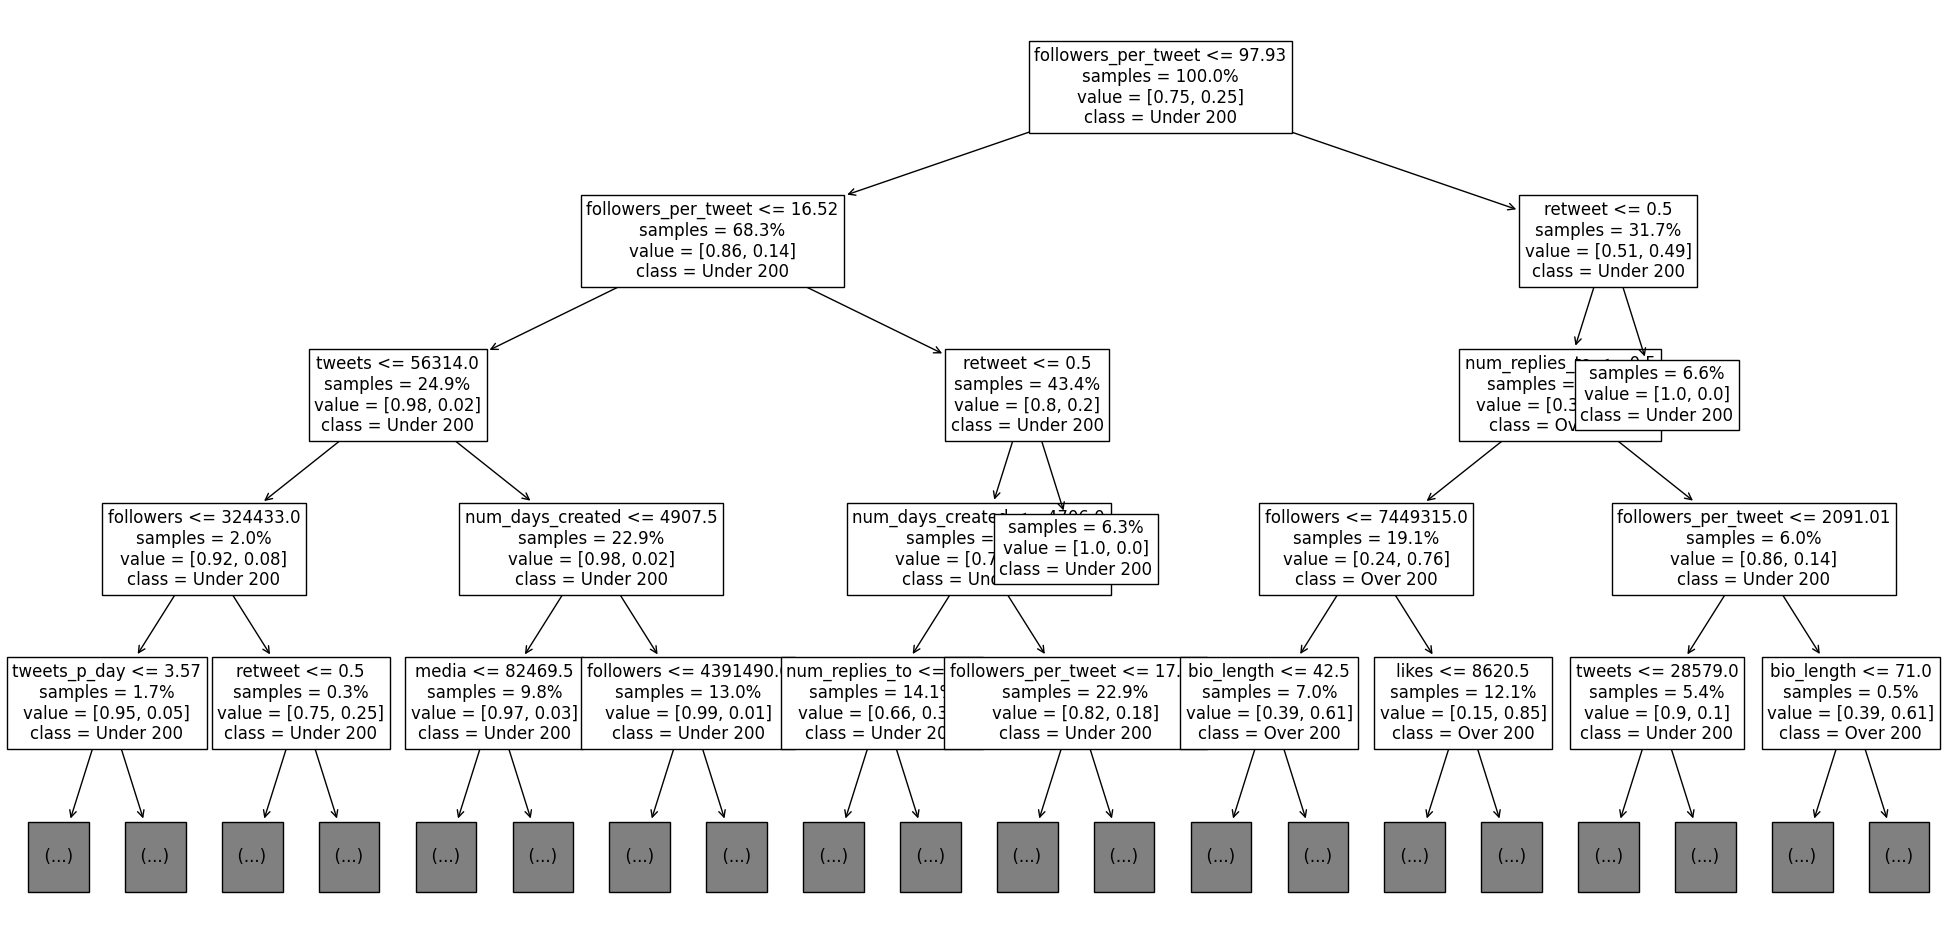

In [22]:
plt.figure(figsize=(25, 12))
sklearn.tree.plot_tree(
    full_pipeline["classifier"],
    fontsize=12,
    feature_names=feature_names,
    class_names=[f"Under {cutoff}", f"Over {cutoff}"],
    max_depth=4,
    impurity=False,
    proportion=True,
    precision=2,
)
plt.show()

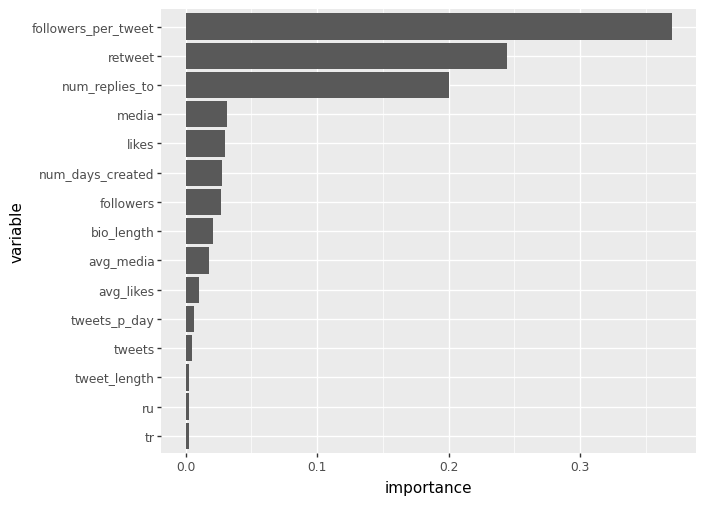

In [23]:
graph_data = pd.DataFrame(
    [
        (imp, variable)
        for imp, variable in zip(
            full_pipeline["classifier"].feature_importances_, feature_names
        )
    ],
    columns=["importance", "variable"],
).sort_values("importance", ascending=False)

limit = 15
graph = (
    pn.ggplot(graph_data.head(limit), pn.aes(x="variable", y="importance"))
    + pn.geom_col()
    + pn.coord_flip()
    + pn.theme(figure_size=(7, 5))
    + pn.scale_x_discrete(limits=graph_data.head(limit).variable.unique()[::-1])
)

graph.draw()

## Random forest y XGBoost

Ahora vamos a intentar replicar lo que hemos hecho, pero utilizando 2 modelos más complejos: RandomForest y XGBoost. Para XGBoost vamos a utilizar otra libreria, pero como veremos, el sintaxis es igual.


In [24]:
numeric_variables = potential_variables
cat_variables = ["language"]

cat_pipeline = sklearn.pipeline.Pipeline(
    [("encoder", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"))]
)

preprocessing = sklearn.compose.ColumnTransformer(
    [
        ("categorical", cat_pipeline, cat_variables),
        ("numeric", "passthrough", numeric_variables),
    ]
)

full_pipeline = sklearn.pipeline.Pipeline(
    [
        ("preprocessing", preprocessing),
        (
            "classifier",
            sklearn.ensemble.RandomForestClassifier(
                random_state=0, n_estimators=500, max_depth=10, min_samples_leaf=5
            ),
        ),
    ]
)

X_variables = numeric_variables + cat_variables
model_no = 2
pred_col = f"predictions_{model_no}"

full_pipeline.fit(train[X_variables], train[target])
train[pred_col] = full_pipeline.predict_proba(train[X_variables])[:, 1]
test[pred_col] = full_pipeline.predict_proba(test[X_variables])[:, 1]

auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(
    f"The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}"
)

The auc in train is 0.938 and in test it is 0.936, the accuracies are 88.4% and 87.8%


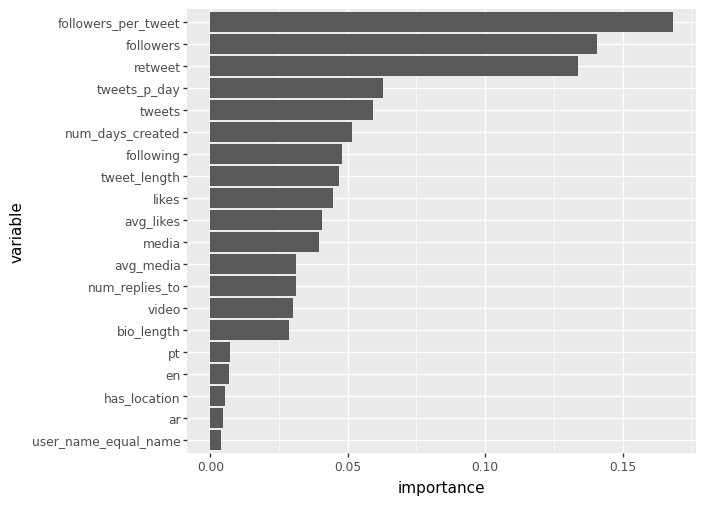

In [25]:
graph_data = pd.DataFrame(
    [
        (imp, variable)
        for imp, variable in zip(
            full_pipeline["classifier"].feature_importances_, feature_names
        )
    ],
    columns=["importance", "variable"],
).sort_values("importance", ascending=False)

limit = 20
graph = (
    pn.ggplot(graph_data.head(limit), pn.aes(x="variable", y="importance"))
    + pn.geom_col()
    + pn.coord_flip()
    + pn.theme(figure_size=(7, 5))
    + pn.scale_x_discrete(limits=graph_data.head(limit).variable.unique()[::-1])
)

graph.draw()

In [35]:
numeric_variables = potential_variables
cat_variables = ["language"]

cat_pipeline = sklearn.pipeline.Pipeline(
    [("encoder", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"))]
)

preprocessing = sklearn.compose.ColumnTransformer(
    [
        ("categorical", cat_pipeline, cat_variables),
        ("numeric", "passthrough", numeric_variables),
    ]
)

full_pipeline = sklearn.pipeline.Pipeline(
    [
        ("preprocessing", preprocessing),
        (
            "classifier",
            xgboost.XGBClassifier(
                random_state=0, n_estimators=100, max_depth=7, min_samples_leaf=5
            ),
        ),
    ]
)

X_variables = numeric_variables + cat_variables
model_no = 3
pred_col = f"predictions_{model_no}"

full_pipeline.fit(train[X_variables], train[target])

full_pipeline.fit(train[X_variables], train[target])
train[pred_col] = full_pipeline.predict_proba(train[X_variables])[:, 1]
test[pred_col] = full_pipeline.predict_proba(test[X_variables])[:, 1]

auc_train = sklearn.metrics.roc_auc_score(train[target], train[pred_col])
auc_test = sklearn.metrics.roc_auc_score(test[target], test[pred_col])

acc_train = sklearn.metrics.accuracy_score(train[target], train[pred_col].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test[pred_col].round())

print(
    f"The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}"
)

c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:52:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.



The auc in train is 0.975 and in test it is 0.951, the accuracies are 92.5% and 89.3%


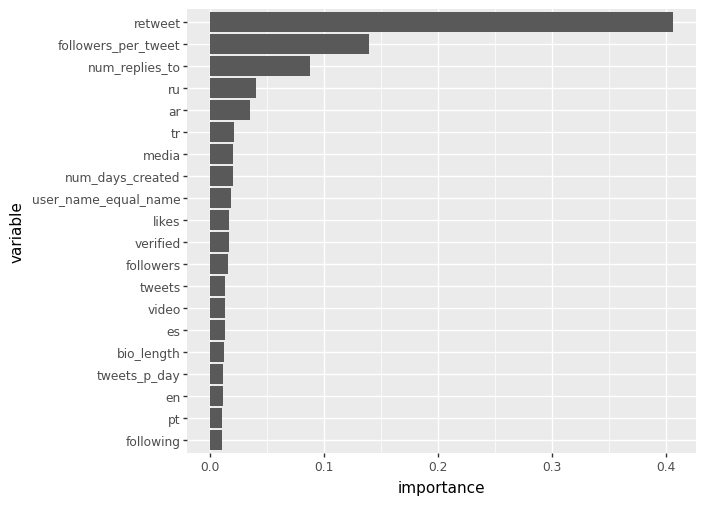

In [27]:
graph_data = pd.DataFrame(
    [
        (imp, variable)
        for imp, variable in zip(
            full_pipeline["classifier"].feature_importances_, feature_names
        )
    ],
    columns=["importance", "variable"],
).sort_values("importance", ascending=False)

limit = 20
graph = (
    pn.ggplot(graph_data.head(limit), pn.aes(x="variable", y="importance"))
    + pn.geom_col()
    + pn.coord_flip()
    + pn.theme(figure_size=(7, 5))
    + pn.scale_x_discrete(limits=graph_data.head(limit).variable.unique()[::-1])
)

graph.draw()

## Comparando la utilidad real


In [38]:
results = []
renames = {0: "recall", 1: "precision", 2: "threshold"}
for i in range(1, 4):
    result = (
        pd.DataFrame(
            sklearn.metrics.precision_recall_curve(
                test[target], test[f"predictions_{i}"]
            )
        )
        .transpose()
        .rename(columns=renames)
    )
    result["prediction_number"] = str(i)
    results.append(result)

results = pd.concat(results)

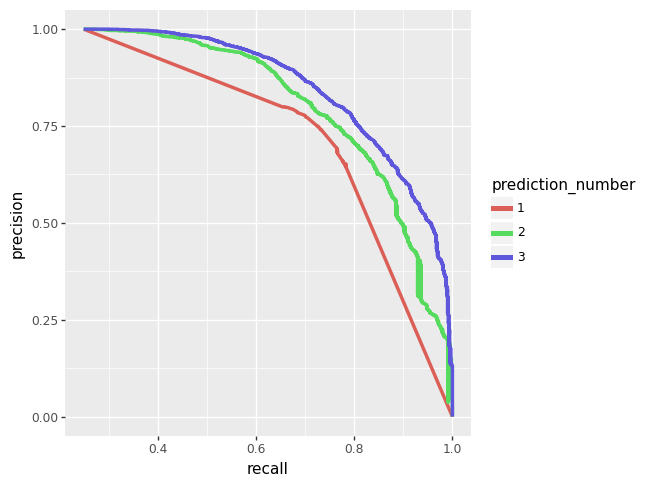

In [39]:
graph = pn.ggplot(
    results, pn.aes(x="recall", y="precision", color="prediction_number")
) + pn.geom_line(size=1.4)

graph.draw()

Apreciamos que podemos conseguir unos resultados bastante mejor para el random forest y XGBoost - conseguimos un 0.4 de recall con asi 100% de precision por ejemplo.
